### 基本库import

In [42]:
#-*- encoding:utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 导入通话记录，短信记录，访问记录数据

In [43]:
names_voice = ['uid','opp_num','opp_head','opp_len','start_time','end_time','call_type','in_out']
# 导入用户通话记录
voice_train = pd.read_table("./data/train/voice_train.txt",sep='\t',header=None,encoding='utf-8',names = names_voice,index_col = False,low_memory=False)
#call_test = pd.read_table("./data/test/voice_test.txt",sep='\t',header=None,encoding='utf-8',names = names_call,index_col = False,low_memory=False)
#call_data = pd.concat([call_train,call_test])


names_sms = ['uid','opp_num','opp_head','opp_len','start_time','in_out']
# 导入用户短信记录
sms_train = pd.read_table("./data/train/sms_train.txt",sep='\t',header=None,encoding='utf-8',names = names_sms,index_col = False,low_memory=False)
#sms_test = pd.read_table("./data/test/sms_test.txt",sep='\t',header=None,encoding='utf-8',names = names_sms,index_col = False,low_memory=False)
#sms_data = pd.concat([sms_train,sms_test])

names_wa = ['uid','wa_name','visit_cnt','visit_dura','up_flow','down_flow','wa_type','date']
# 导入用户通话记录
wa_train = pd.read_table("./data/train/wa_train.txt",sep='\t',header=None,encoding='utf-8',names = names_wa,index_col = False,low_memory=False)
#wa_test = pd.read_table("./data/test/wa_test.txt",sep='\t',header=None,encoding='utf-8',names = names_wa,index_col = False,low_memory=False)
#wa_data = pd.concat([wa_train,wa_test])


### 1. 对用户的电话接拨情况统计

In [57]:
## 每个用户的电话总数量 丢
voice_count = voice_train.groupby('uid')['in_out'].count()
voice_count.fillna(0,inplace=True)
## 每个用户收/发电话的总数
voice_count_by_inout = voice_train.groupby(['uid','in_out'])['opp_len'].count().unstack('in_out').rename(columns={0:'send_voice_cnt',1:'recv_voice_cnt'})
voice_count_by_inout.fillna(0,inplace=True)
## 每个用户收/发电话的号码的平均长度
voice_mean_opp_len_by_inout = voice_train.groupby(['uid','in_out'])['opp_len'].mean().unstack('in_out').rename(columns={0:'send_voice_opplen',1:'recv_voice_opplen'})
voice_mean_opp_len_by_inout.fillna(0,inplace=True)
## 每个用户通话的平均时长和最长时长 丢
voice_train['dura']=abs(voice_train.end_time-voice_train.start_time)
voice_mean_dura = voice_train.groupby('uid')['dura'].mean().rename(columns={1:'mean_dura'})
voice_max_dura = voice_train.groupby('uid')['dura'].max().rename(columns={1:'max_dura'})

## 每个用户每种通话类型的次数
voice_train['call_type'] = voice_train['call_type'].astype('category')
voice_count_by_type = voice_train.groupby(['uid','call_type'])['opp_len'].count().unstack('call_type').rename(columns={1:'Cbendi',2:'Cshengnei',3:'Cshengji',4:'Cgangaotai',5:'Cguoji'})
voice_count_by_type.fillna(0,inplace=True)
## 每个用户每种通话类型的平均时长
voice_train['call_type'] = voice_train['call_type'].astype('category')
voice_dura_by_type = voice_train.groupby(['uid','call_type'])['dura'].mean().unstack('call_type').rename(columns={1:'Dbendi',2:'Dshengnei',3:'Dshengji',4:'Dgangaotai',5:'Dguoji'})
voice_dura_by_type.fillna(0,inplace=True)
## 结合数据
voice = pd.concat([voice_count_by_inout,voice_mean_opp_len_by_inout,voice_max_dura,voice_count_by_type,voice_dura_by_type],axis =1).reset_index().rename(columns={'in_out':'sms_total_cnt',0:'mean_dura',1:'max_dura'})

### 2. 对用户的短信收发情况统计

In [45]:
## 每个用户的短信总数量 丢
sms_count = sms_train.groupby('uid')['in_out'].count()
sms_count.fillna(0,inplace=True)
## 每个用户收/发短信的总数
sms_count_by_inout = sms_train.groupby(['uid','in_out'])['opp_len'].count().unstack('in_out').rename(columns={0:'send_sms_cnt',1:'recv_sms_cnt'})
sms_count_by_inout.fillna(0,inplace=True)
## 每个用户收/发短信的号码的平均长度
sms_mean_opp_len_by_inout = sms_train.groupby(['uid','in_out'])['opp_len'].mean().unstack('in_out').rename(columns={0:'send_sms_opplen',1:'recv_sms_opplen'})
sms_mean_opp_len_by_inout.fillna(0,inplace=True)
## 结合数据
sms = pd.concat([sms_count_by_inout,sms_mean_opp_len_by_inout],axis =1).reset_index().rename(columns={'in_out':'sms_total_cnt'})

### 3. 对用户的W/A访问情况统计

In [46]:
wa_train['wa_name'] = wa_train['wa_name'].astype('category')
#每个用户的总访问时长 丢
wa_dura_sum = wa_train.groupby('uid')['visit_dura'].sum()
wa_dura_sum.fillna(0,inplace=True)
## 每个用户web/APP时长
wa_dura_by_type = wa_train.groupby(['uid','wa_type'])['visit_dura'].sum().unstack('wa_type').rename(columns={0.0:'web_dura',1.0:'APP_dura'})
wa_dura_by_type.fillna(0,inplace=True)
## 每个用户web/APP上行流量
wa_up_flow_by_type = wa_train.groupby(['uid','wa_type'])['up_flow'].sum().unstack('wa_type').rename(columns={0.0:'web_up_flow',1.0:'APP_up_flow'})
wa_up_flow_by_type.fillna(0,inplace=True)
## 每个用户web/APP下行流量
wa_down_flow_by_type = wa_train.groupby(['uid','wa_type'])['down_flow'].sum().unstack('wa_type').rename(columns={0.0:'web_down_flow',1.0:'APP_down_flow'})
wa_down_flow_by_type.fillna(0,inplace=True)
## 结合数据
wa = pd.concat([wa_dura_by_type,wa_up_flow_by_type,wa_down_flow_by_type],axis =1).reset_index().rename(columns={0:'visit_dura_total','index':'uid'})

### 读取训练与测试数据

In [47]:
uid_label_train = pd.read_table("./data/train/uid_train.txt",sep='\t',header=None,names=['uid','label'])
#uid_label_test =  pd.read_table("./data/test/uid_test.txt",sep='\t',header=None,names=['uid','label'])


### 数据合并

In [58]:
train = uid_label_train.merge(voice,how='outer',right_on='uid',left_on='uid')
train = train.merge(sms,how='outer',right_on='uid',left_on='uid')
train = train.merge(wa,how='outer',right_on='uid',left_on='uid')
train.fillna(0,inplace=True)

#test = uid_label_test.merge(voice,how='outer',right_on='uid',left_on='uid')
#test = test.merge(sms,how='outer',right_on='uid',left_on='uid')
#test = test.merge(wa,how='outer',right_on='uid',left_on='uid')

## 可视化探索

In [49]:
train.describe()

,label,send_voice_cnt,recv_voice_cnt,send_voice_opplen,recv_voice_opplen,mean_dura,max_dura,Cbendi,Cshengnei,Cshengji,...,send_sms_cnt,recv_sms_cnt,send_sms_opplen,recv_sms_opplen,web_dura,APP_dura,web_up_flow,APP_up_flow,web_down_flow,APP_down_flow
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,...,4999.000000,4999.000000,4999.000000,4999.000000,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03
mean,0.180036,118.073815,112.127826,10.199518,10.363670,480.204476,24972.467293,202.984797,11.521304,15.664533,...,15.157431,45.449890,7.439704,9.080087,2.861124e+07,2.144179e+07,1.583803e+08,1.054595e+08,1.809306e+09,1.485466e+09
std,0.384256,252.563086,191.333194,2.376464,2.371623,2760.769453,124071.244898,381.146046,36.965358,43.866751,...,60.652737,98.000289,4.784824,4.717637,4.081003e+07,3.110368e+07,3.829703e+08,2.449153e+08,4.166696e+09,3.774417e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,11.000000,12.000000,10.695284,10.926538,122.649599,1104.500000,20.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,9.447222,1.745446e+06,8.217235e+05,3.507695e+06,1.892666e+06,2.090244e+07,1.355523e+07
50%,0.000000,44.000000,46.000000,10.974239,11.000000,210.250000,4502.000000,76.000000,1.000000,1.000000,...,2.000000,18.000000,10.400000,11.000000,1.302296e+07,9.204106e+06,3.662698e+07,2.821493e+07,2.943838e+08,2.537132e+08
75%,0.000000,120.000000,126.000000,11.000000,11.012821,342.415232,6017.500000,210.500000,6.000000,12.000000,...,9.000000,52.000000,11.000000,12.200000,3.896718e+07,2.942111e+07,1.550206e+08,1.085044e+08,1.411635e+09,1.160564e+09
max,1.000000,7972.000000,3051.000000,18.333333,14.800000,127416.333333,779493.000000,7964.000000,512.000000,895.000000,...,1181.000000,3478.000000,20.000000,14.000000,4.434289e+08,3.066937e+08,1.152570e+10,6.729532e+09,6.041122e+10,7.142913e+10


Text(0,0.5,'people')

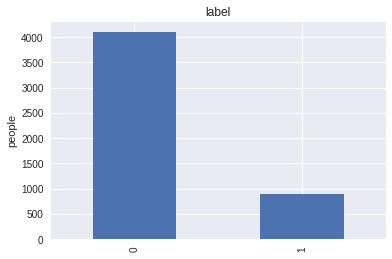

In [50]:
# 两种类别的分布
train.label.value_counts().plot(kind='bar') 
plt.title(u"label")
plt.ylabel(u"people")

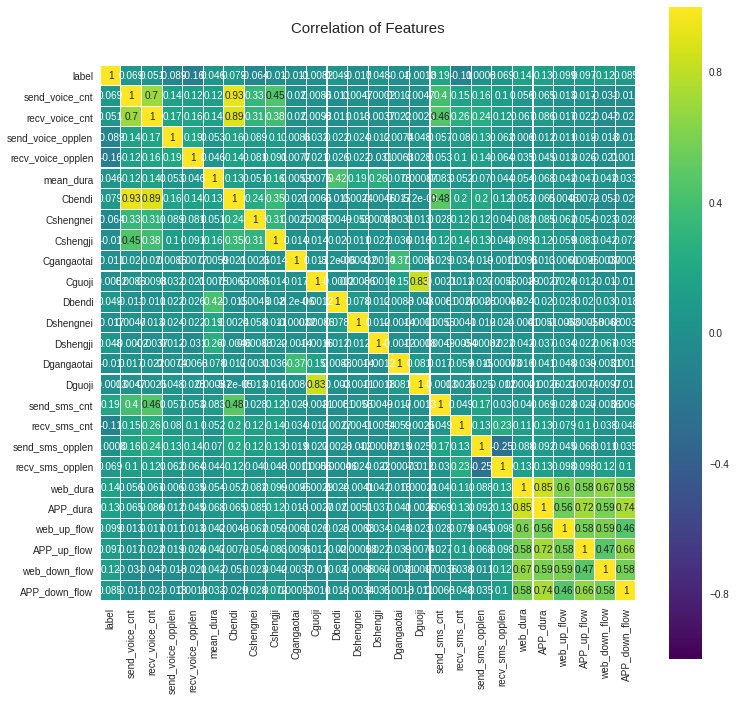

In [59]:
features = train.drop(['uid'],axis=1)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(features.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### X_train为训练集的特征，X_test为测试集的特征，y_train是训练集的标签

In [82]:
X_train = train.drop(['uid','label'],axis=1)
#X_test = test.drop(['uid','label'],axis=1)
y_train = train.label

/home/suhuiling/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/suhuiling/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


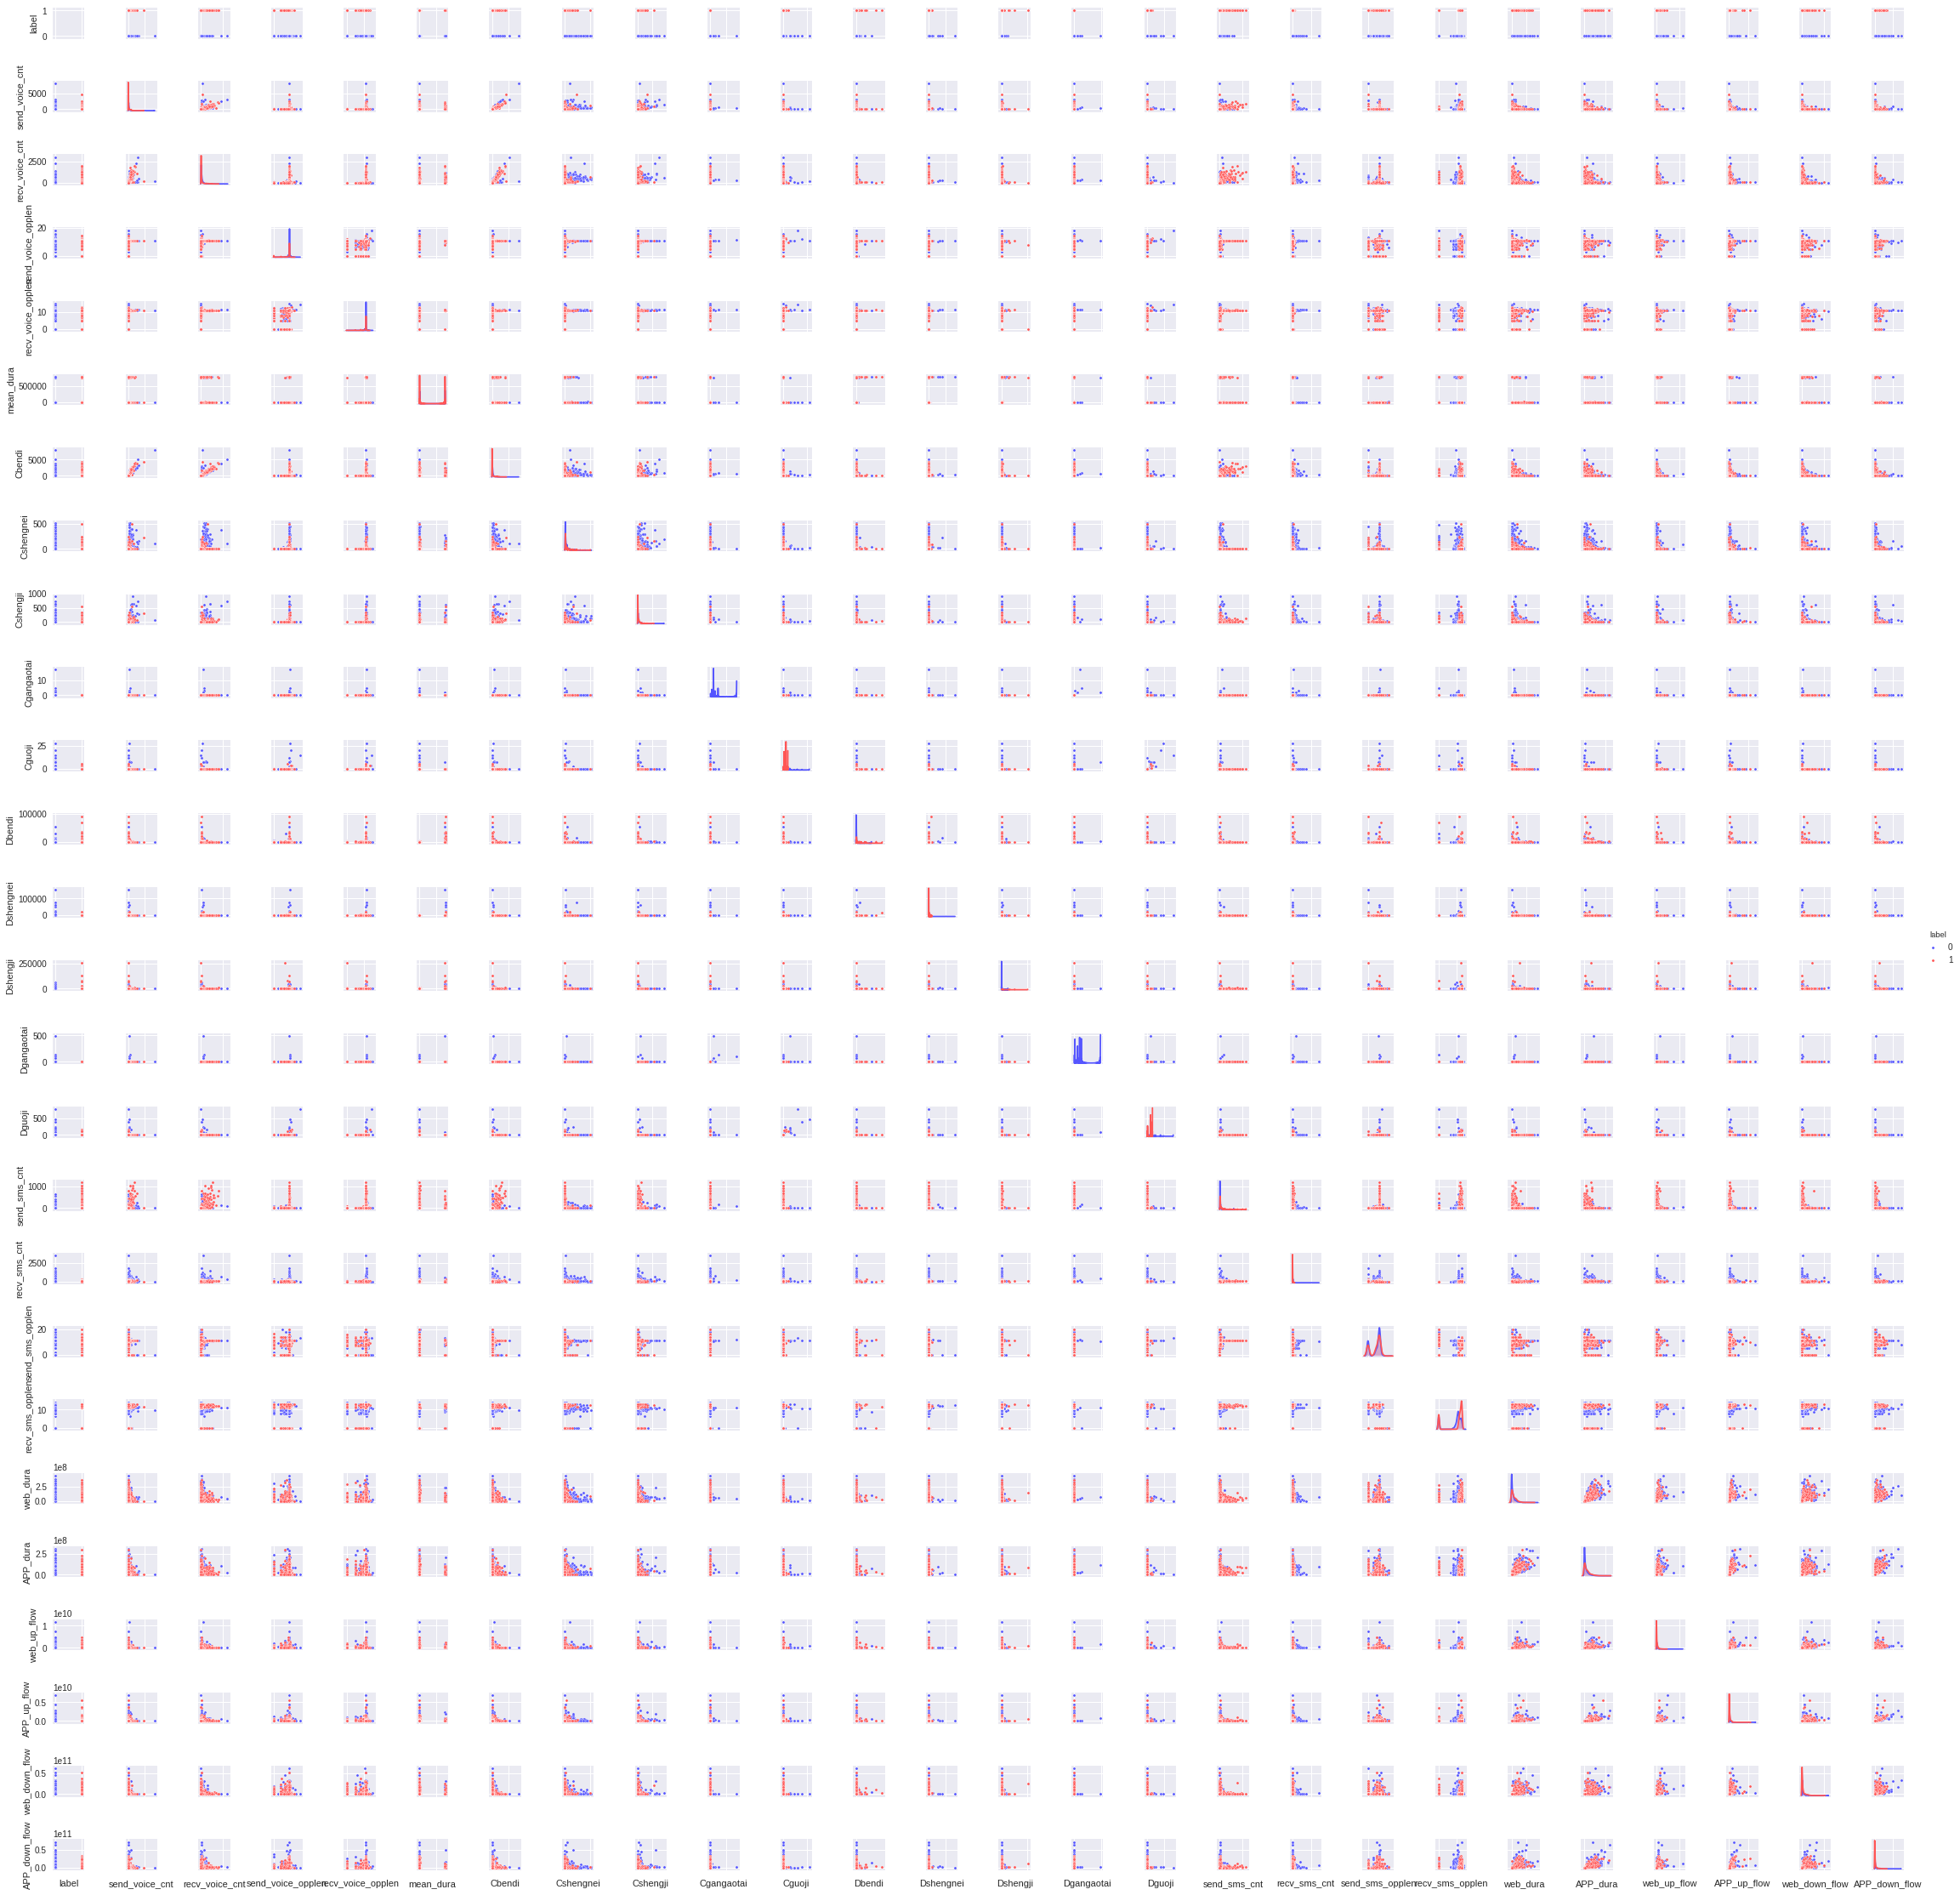

In [91]:
g = sns.pairplot(train, hue='label', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## 选择合适的分类器

/home/suhuiling/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suhuiling/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/suhuiling/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/suhuiling/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/suhuiling/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-

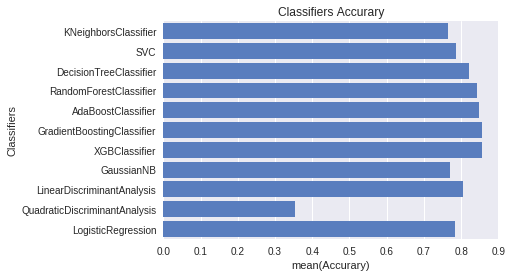

In [83]:
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(), 
    AdaBoostClassifier(), 
    GradientBoostingClassifier(),
    XGBClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifiers", "Accurary"]
log      = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = X_train.values
y = y_train.values

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
    	name = clf.__class__.__name__
    	clf.fit(X_train, y_train)
    	train_predictions = clf.predict(X_test)
    	acc = 0.6*accuracy_score(y_test, train_predictions)+0.4*f1_score(y_test, train_predictions,average='weighted')
    	if name in acc_dict:
    		acc_dict[name] += acc
    	else:
    		acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel("Accurary")
plt.title("Classifiers Accurary")

sns.set_color_codes("muted")
sns.barplot(x ='Accurary', y = 'Classifiers', data=log, color='b')

## xgb 参数配置，自定义评价函数

In [53]:
xgb_params = {
    'booster':'gbtree',
    'objective':'multi:softmax',
    'stratified':True,
    'max_depth':10,
    # 'gamma':1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    # 'lambda':1,
    'eta':0.5,
    'seed':20,
    'silent':1,
    'num_class':2
}
def evalScore(preds,dtrain):
    label = dtrain.get_label()
    return 'sco',0.4*f1_score(label,preds,average='weighted')+0.6*accuracy_score(label,preds)

## 线下cv

In [71]:
dtrain = xgb.DMatrix(X_train,label=y_train)
xgb.cv(xgb_params,dtrain,num_boost_round=200,nfold=3,verbose_eval=10,
       early_stopping_rounds=100,maximize=True,feval=evalScore)

[0]	train-merror:0.0680137+0.00875099	train-sco:0.930544+0.00945789	test-merror:0.165815+0.0127934	test-sco:0.829255+0.0134942
[10]	train-merror:0.000889+0.000156978	train-sco:0.99911+0.000157449	test-merror:0.145366+0.0067054	test-sco:0.850338+0.00717612
[20]	train-merror:0+0	train-sco:1+0	test-merror:0.144921+0.00654187	test-sco:0.851208+0.00714496
[30]	train-merror:0+0	train-sco:1+0	test-merror:0.148478+0.00680733	test-sco:0.84747+0.00740406
[40]	train-merror:0+0	train-sco:1+0	test-merror:0.14781+0.00664337	test-sco:0.848179+0.00737082
[50]	train-merror:0+0	train-sco:1+0	test-merror:0.146922+0.0071957	test-sco:0.84929+0.00790603
[60]	train-merror:0+0	train-sco:1+0	test-merror:0.146032+0.00713283	test-sco:0.850329+0.0077111
[70]	train-merror:0+0	train-sco:1+0	test-merror:0.146032+0.00713283	test-sco:0.850369+0.00766001
[80]	train-merror:0+0	train-sco:1+0	test-merror:0.146477+0.006844	test-sco:0.849991+0.0072945
[90]	train-merror:0+0	train-sco:1+0	test-merror:0.147365+0.00587703	test-

,test-merror-mean,test-merror-std,test-sco-mean,test-sco-std,train-merror-mean,train-merror-std,train-sco-mean,train-sco-std
0,0.165815,0.012793,0.829255,0.013494,0.068014,0.008751,0.930544,0.009458
1,0.160925,0.006542,0.833792,0.006033,0.045566,0.005879,0.953626,0.006140
2,0.155589,0.013656,0.838391,0.014204,0.030896,0.002889,0.968735,0.002955
3,0.153365,0.010401,0.841042,0.011222,0.020227,0.003627,0.979607,0.003681
4,0.151810,0.009567,0.842640,0.010859,0.011892,0.002317,0.988052,0.002333
5,0.148922,0.010348,0.846105,0.011283,0.007113,0.001344,0.992868,0.001353
6,0.148922,0.008173,0.846572,0.008945,0.004556,0.000415,0.995435,0.000417
7,0.147811,0.007791,0.847837,0.008453,0.002778,0.000415,0.997218,0.000416
8,0.144255,0.007762,0.851463,0.008214,0.001889,0.000416,0.998109,0.000416
9,0.145588,0.005985,0.850132,0.006440,0.001000,0.000272,0.998999,0.000273


### 训练模型

In [55]:
model=xgb.train(xgb_params,dtrain=dtrain,num_boost_round=190,verbose_eval=10,
                evals=[(dtrain,'train')],maximize=True,feval=evalScore,early_stopping_rounds=100)

[0]	train-merror:0.078016	train-sco:0.919728
Multiple eval metrics have been passed: 'train-sco' will be used for early stopping.

Will train until train-sco hasn't improved in 100 rounds.
[10]	train-merror:0.0008	train-sco:0.9992
[20]	train-merror:0	train-sco:1
[30]	train-merror:0	train-sco:1
[40]	train-merror:0	train-sco:1
[50]	train-merror:0	train-sco:1
[60]	train-merror:0	train-sco:1
[70]	train-merror:0	train-sco:1
[80]	train-merror:0	train-sco:1
[90]	train-merror:0	train-sco:1
[100]	train-merror:0	train-sco:1
[110]	train-merror:0	train-sco:1
Stopping. Best iteration:
[14]	train-merror:0	train-sco:1



### 预测

In [56]:
dtest = xgb.DMatrix(X_test)
preds =model.predict(dtest)

NameError: name 'X_test' is not defined

### 保存提交结果

In [ ]:
ID_test['label'] =preds
ID_test['label']=ID_test['label']
ID_test.to_csv('../result/baseline_res.csv',index=None)